In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
import torch.distributions as td
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm



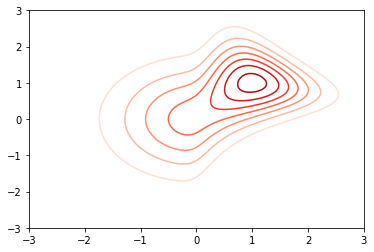

In [10]:
from run_2d import likelihood

torch.set_default_dtype(torch.float32)
device=torch.device("cpu")
z1, z2 = torch.meshgrid(torch.linspace(-3,3,100), torch.linspace(-3,3,100))
zz = torch.stack([z1,z2], dim=-1).reshape(-1, 2).to(device)

x = torch.tensor([2])

# the second argument specifies the likelihoods. 
# The two in the paper are "sym" and "soft"
lik_fun = lambda zz: likelihood(zz, "soft").log_prob(x)


prior = td.Independent(td.Normal(torch.zeros(2), torch.ones(2)), 1)

post = prior.log_prob(zz) + lik_fun(zz)
post -= post.max()
post = post.exp()/post.exp().sum()

plt.contour(z1, z2, post.detach().numpy().reshape(100,100), cmap="Reds")

In [34]:
# use how many Gaussian components 
ncomp=10
niter = 1000

# if using a single gaussian, whether to use reparametrized samples
reparam = False
n_post_sample = 10


torch.random.manual_seed(1)

if ncomp >1 :
    # set up Gaussian mixture parameters
    logits = torch.zeros(ncomp, requires_grad=True)
    m = prior.sample([ncomp])
    m.requires_grad_()
    s = torch.zeros(ncomp, 2, requires_grad=True)
    opt = torch.optim.Adam([logits,m,s],lr=0.001)

else:
    # set up single-Gaussian parameters
    m = torch.zeros(2, requires_grad=True)
    s = torch.zeros(2, requires_grad=True)
    opt = torch.optim.SGD([m,s],lr=0.001)

losses = []
ms = []
logitss = []
kls = []


for i in tqdm.trange(5000):

    if ncomp > 1:
        mix = td.Categorical(logits=logits)
        comp = td.Independent(td.Normal(m, s.exp()), 1)
        q =td.mixture_same_family.MixtureSameFamily(mix, comp)
    else:
        q = td.Independent(td.Normal(m, torch.tensor([0.7172, 0.5990])), 1)

    # use 10 posteri
    if reparam:
        z = q.rsample([n_post_sample])
    else:
        z = q.sample([n_post_sample])
        z.requires_grad=True

    dlogpz   = -z
    dlogqz_x = torch.autograd.grad(q.log_prob(z).sum(), [z], create_graph=True)[0]
    dlogpx_z = torch.autograd.grad(lik_fun(z).sum(), [z], create_graph=True)[0]
#     dlogqz_x = - (z - q.mean) / q.stddev**2
# #     dlogpx_z =  (x - softplus(z[...,0]) * z[...,1] )[:,None] / std**2 * torch.stack([z[...,1] * torch.sigmoid(z[...,0]), softplus(z[...,0])], -1)
#     dlogpx_z =  (x - torch.relu(z[...,0]) * z[...,1] )[:,None] / std**2 * torch.stack([z[...,1] * (torch.sign(z[...,0])+1)/2, torch.relu(z[...,0])], -1)


    score = (dlogqz_x - (dlogpz + dlogpx_z)).square().sum(-1)
    loss = score.mean()

    losses += loss.item(),

    if ncomp == 1:
        kl = - lik_fun(z).mean() + td.kl.kl_divergence(q,prior)
        kls += kl.item(),

    opt.zero_grad()
    loss.backward()
    opt.step()

    ms += m.detach().numpy().copy(),
    if ncomp > 1:
        logitss += logits.detach().numpy().copy(),

Text(0.5, 1.0, 'KLD')

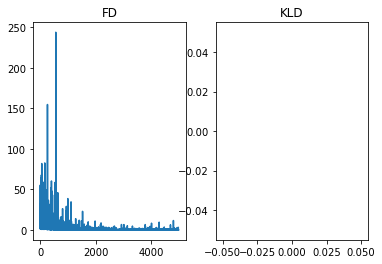

In [35]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.plot(losses)
ax.set_title("FD")

ax = axes[1]
ax.plot(kls)
ax.set_title("KLD")

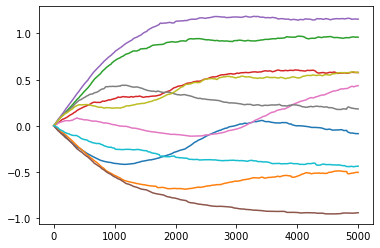

In [36]:
plt.plot(logitss);

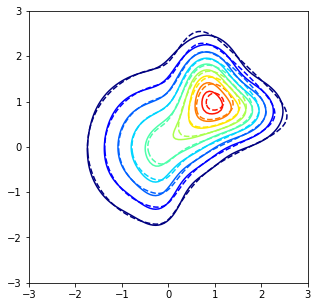

In [37]:
Ngrid = 100
z1, z2 = torch.meshgrid(torch.linspace(-3,3,Ngrid), torch.linspace(-3,3,Ngrid))
zz = torch.stack([z1,z2], dim=-1).reshape(-1, 2).to(device)


fig, ax= plt.subplots(figsize=(5,5), sharex=True, sharey=True)

qpost = q.log_prob(zz)
qpost -= qpost.max()
qpost = qpost.exp()/qpost.exp().sum()

ax.contour(z1, z2, post.detach().numpy().reshape(100,100), np.linspace(0.0001,0.0008,10), cmap="jet", linestyles="--")
ax.contour(z1, z2, qpost.detach().numpy().reshape(100,100), np.linspace(0.0001,0.0008,10), cmap="jet")
